<a href="https://colab.research.google.com/github/music-ai-644/AI_Study_2022/blob/main/week5_quiz_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression

## 자동차 연비 예측하기: 회귀 
1. 데이터셋 불러오기 

In [ ]:
# 산점도 행렬을 그리기 위해 seaborn 패키지를 설치합니다
!pip install seaborn
import torch
import random
import torch.nn as nn 
import pathlib
import numpy as np 

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
print(tf.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2.8.2


In [ ]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/root/.keras/datasets/auto-mpg.data'

In [ ]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset = dataset.dropna()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


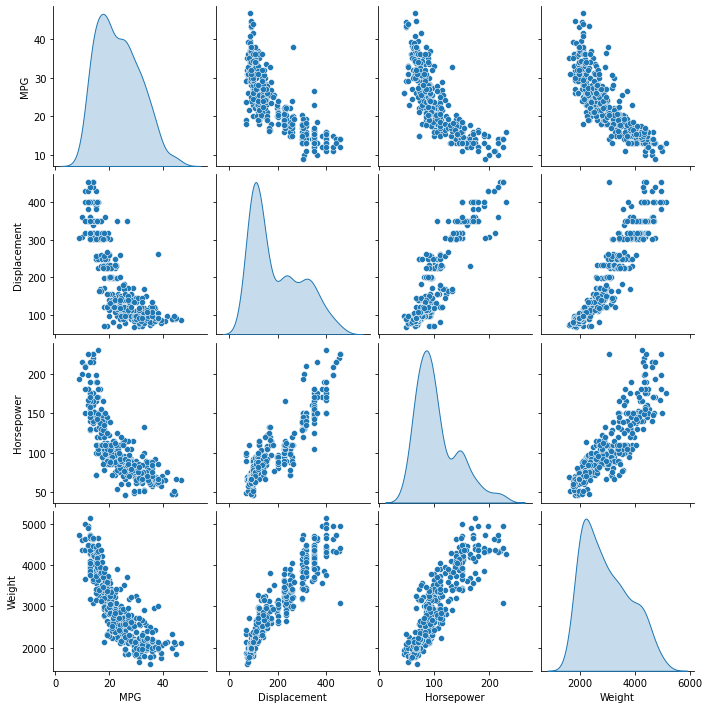

In [ ]:
sns.pairplot(dataset[["MPG", "Displacement", "Horsepower", "Weight"]], diag_kind="kde")

MPG = 연비, Cylinders = 실린더 개수, Displacement = 배기량, Horseposer = 마력, Weight = 중량, Acceleration = 가속

2. 데이터셋을 numpy로 수정하고 학습 데이터셋 준비

In [ ]:
dataset = dataset.to_numpy()
x = dataset[:, 1:]
y = dataset[:, 0]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)  # 수정 금지 
x_train, x_eval, y_train, y_eval = train_test_split(x_train, y_train, test_size=0.125, random_state=999)

x_train_torch = torch.FloatTensor(x_train)
y_train_torch = torch.FloatTensor(y_train)
x_eval_torch = torch.FloatTensor(x_eval)
y_eval_torch = torch.FloatTensor(y_eval) 
x_test_torch = torch.FloatTensor(x_test)
y_test_torch = torch.FloatTensor(y_test)

In [ ]:
class RegressionNeuron(nn.Module):
  def __init__(self, in_dim=7, n_hidden=60, learning_rate=1e-4):
    '''
    Args:
      in_dim: The dimension of input data  
      n_hidden: The dimension of hidden layer
      learning_rate: The initial learning rate for training a network 
    '''
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(in_dim, n_hidden),
        nn.ReLU(), 
        nn.Linear(n_hidden, 1)
        )
    
    self.optim = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
    self.criterion = nn.MSELoss()

  def _calculate_loss(self, x, y):
    loss = self.criterion(x, y)
    return loss 

  def forward(self, x):
    z = self.model(x)
    return z

  def train(self, x, y, epochs=100):
    for i in range(epochs):
      for x_i, y_i in zip(x, y):
        pred_y = self.forward(x_i)
        loss = self._calculate_loss(pred_y[0], y_i)
        self.model.zero_grad() 
        self.optim.zero_grad()
        loss.backward()
        self.optim.step()

      if (i+1) % 10 == 0:  # 여기 나누는 값을 조정해서 프린트하는 횟수를 조절
        eval_loss = np.mean((self.predict(x_eval_torch) - y_eval)**2)
        print("epoch {} : err = {:.4f}, eval err = {:.4f}".format(i + 1, loss, eval_loss))

  def predict(self, x):
    output = self.forward(x)
    output = output.data.numpy() 
    return output 

In [ ]:
random_seed = 123
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)

neuron = RegressionNeuron(in_dim=7, n_hidden=100, learning_rate=1e-4)
neuron.train(x_train_torch, y_train_torch)

epoch 10 : err = 19.0902, eval err = 75.8513
epoch 20 : err = 8.8612, eval err = 104.8630
epoch 30 : err = 2.0885, eval err = 109.5166
epoch 40 : err = 0.0607, eval err = 112.3529
epoch 50 : err = 0.0655, eval err = 119.9832
epoch 60 : err = 0.4166, eval err = 130.7557
epoch 70 : err = 0.8452, eval err = 139.0720
epoch 80 : err = 1.3485, eval err = 146.7157
epoch 90 : err = 1.2861, eval err = 149.2607
epoch 100 : err = 1.6011, eval err = 151.5371


In [ ]:
output = np.mean((neuron.predict(x_test_torch) - y_test)**2)
print(output)

130.37403392608192
